In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

For our summarization task we would use our second dataset that contains 134010 lines.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df1 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG01.json')
df2 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG02.json')
df3 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG03.json')
df4 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG04.json')
df5 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG05.json')
df6 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG06.json')
df7 = pd.read_json('/content/drive/My Drive/RusPaperFull/RG07.json')

In [4]:
full_data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
print("Total lines in base dataframe:", len(full_data))
print("Total duplicated lines:", len(full_data[full_data.duplicated(keep='first')]))
df = full_data.drop_duplicates()
print("Total unique lines in cleaned dataframe:", len(df))

Total lines in base dataframe: 134010
Total duplicated lines: 16
Total unique lines in cleaned dataframe: 133994


Let's have a first look at our data common stats.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133994 entries, 0 to 19136
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Article_id     133994 non-null  int64 
 1   Url            133994 non-null  object
 2   Date_time      133994 non-null  object
 3   Head_rubric    130537 non-null  object
 4   Head_title     133857 non-null  object
 5   Head_subtitle  29880 non-null   object
 6   Text           133889 non-null  object
 7   Keywords       133509 non-null  object
 8   Authors        133509 non-null  object
dtypes: int64(1), object(8)
memory usage: 10.2+ MB


At first we have 105 Null cells in Text column in dataframe that was not collected automatically due to specific of html and css formatting of some special news pages. And secondly we see 137 empty cells which must contain news titles. Let's get only lines that are full of texts.

In [6]:
df = df[df['Text'].notna()]
df = df[df['Head_title'].notna()]
print("Total unique lines in final dataframe:", len(df))

Total unique lines in final dataframe: 133857


In [0]:
df = df.sort_values('Date_time')

We sort our data for DateTime. When dividing data to training set and a test set, earlier data should put to the training set for preserving the time series. Now we have 603 lines that contains "0001-01-01T00:00:00" DateTime value. This happened during parsing process, when some news hadn't got any time stamps. Min value DateTime was automatically added. These lines represent only 0.5% of the total data set, save them too.

After all for our summarization task we don't need any column except "Text" that to be used as inputs and "Head_title" that to be used as targets.

**Но сначала соберём немного статистики по датасету для его анализа. Для этого уберём колонки, которые не несут для нас полезной информации.**

In [0]:
df = df.drop(['Article_id', 'Url', 'Date_time', 'Head_subtitle', 'Authors'], axis=1)
df = df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133857 entries, 0 to 133856
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Head_rubric  130537 non-null  object
 1   Head_title   133857 non-null  object
 2   Text         133857 non-null  object
 3   Keywords     133375 non-null  object
dtypes: object(4)
memory usage: 4.1+ MB


**Определим несколько вспомогательных функций.**

In [0]:
def get_rubrics_stat(dataset):
    unique_rubrics = dataset.Head_rubric.unique()
    print("Total rubrics:", len(unique_rubrics))
    rubrics = {}
    for item in unique_rubrics:
        if item is None:
            rubrics[item] = len(dataset[dataset["Head_rubric"].isna()])
            continue
        rubrics[item] = len(dataset[dataset["Head_rubric"] == item])
    return rubrics

    
def show_rubrics_stat(rubrics):    
    sorted_r = {k: v for k, v in sorted(rubrics.items(), key=lambda item: item[1], reverse=True)}
    for k, v in sorted_r.items():
        print("%s: %s" % (k, v))


def replace_minor_headrubrics(dataset, stats, threshold):
    major = []
    minor = []
    for key, val in stats.items():
        if val > threshold:
            major.append(key)
        else:
            minor.append(key)
    for name in minor:
        temp = dataset[dataset['Head_rubric'] == name]
        new = None
        flag = False
        for _, row in temp.iterrows():
            if row['Keywords'] is None:
                continue
            keywords = [x.strip() for x in row['Keywords'].split(',')]
            for item in keywords:
                if item in major:
                    new = item
                    flag = True
                    break
            if flag: break
        dataset.Head_rubric[dataset.Head_rubric == name] = new


def relabel_empty_headrubrics(dataset, stats):
    head_rubrics = [x for x in stats.keys() if x is not None]
    for index, row in dataset.iterrows():
        if row['Head_rubric'] is None:
            if row['Keywords'] is None:
                continue
            keywords = [x.strip() for x in row['Keywords'].split(',')]
            for item in keywords:
                if item in head_rubrics:
                    row['Head_rubric'] = item
                    continue

In [11]:
hr_stat = get_rubrics_stat(df)
show_rubrics_stat(hr_stat)

Total rubrics: 78
Спорт: 20553
Происшествия: 20122
В мире: 18585
Власть: 18533
Общество: 18301
Культура: 17087
Экономика: 16874
None: 3320
Бензин: 66
Транспорт: 51
Внутренняя политика: 39
Работа власти: 28
ДТП: 27
Транспортное право: 23
Административное право: 19
Общественный транспорт: 19
Инфраструктура: 18
Промышленность: 14
Госуправление: 12
Товары и цены: 11
Безопасность: 10
Долги и кредиты: 9
Налоги: 9
Охрана порядка: 8
Страхование: 7
Суд: 6
Криминал: 6
Образ жизни: 6
Регионы: 5
Право: 5
Крупные компании: 5
Германия: 5
Легковые авто: 5
Уголовное право: 4
Аукционы и коллекции: 3
Внешняя политика: 3
Правоохранительная система: 3
Япония: 3
США: 3
Социология: 3
Позиция: 2
Личные документы: 2
Актуальное искусство: 2
Нефть и газ: 2
Туризм: 2
Соцсфера: 2
Наука: 2
Гражданское право: 2
Дороги: 2
Кино и ТВ: 1
Игроки и тренеры: 1
Литература: 1
Земля: 1
Жилищное право: 1
Железные дороги: 1
ТВ и сериалы: 1
ЖКХ: 1
Банки: 1
Живопись: 1
Правосудие: 1
Бразилия: 1
ЧП: 1
Великобритания: 1
Образовани

**Помимо 7 базовых новостных категорий в маркировке встречаются так же узкоспециальные лейблы, которые представлены всего несколькими новостными текстами. Максимально для такой минорной категории насчитывается 66 текстов. Переразметим каждый такой текст, взяв подходящую метку из списка Keywords, который включает в том числе и метки соответствующие одной из базовых категорий.**

In [0]:
replace_minor_headrubrics(df, hr_stat, threshold=66)

In [13]:
hr_stat = get_rubrics_stat(df)
show_rubrics_stat(hr_stat)

Total rubrics: 8
Спорт: 20554
Происшествия: 20171
Власть: 18697
В мире: 18602
Общество: 18320
Культура: 17097
Экономика: 17096
None: 3320


**После переразметки текстов из минорных категорий у нас осталось 3320 текстов без меток вовсе. Разметим их аналогично, взяв подходящую метку из списка Keywords.**

In [0]:
relabel_empty_headrubrics(df, hr_stat)

In [15]:
show_rubrics_stat(get_rubrics_stat(df))

Total rubrics: 8
Спорт: 20561
Происшествия: 20227
Власть: 19092
В мире: 18788
Общество: 18579
Культура: 18416
Экономика: 18193
None: 1


**У нас остался один текст, для которого изначально не было метки категории и был пустой список Keywords. Посмотрим что это за новость.**

In [16]:
df[df['Head_rubric'].isna()]

,Head_rubric,Head_title,Text,Keywords
148,None,Декрет Высшего Государственного Совета Союзног...,Принят Парламентским Собранием Союза Беларуси ...,None


**Новость представляет собой публикацию нормативно-правового акта Республики Беларусь. Данный текст не представляет для нас ценности, т.к. подобная публикация носит формальный характер и фактически не отражает каких-либо произошедших событий. Удалим этот единственный текст и колонку Keywords, и получим окончательный набор в датасете с которым продолжим работу.**

In [0]:
df.drop([148], inplace=True)
df.drop(['Keywords'], axis=1, inplace=True)
cleaned_dataset = df.reset_index(drop=True)

In [19]:
cleaned_dataset.head()

,Head_rubric,Head_title,Text
0,Культура,Февральские тезисы от Солженицына,Тезис первый: В революции обычно побеждают не ...
1,Экономика,Роспотребнадзор: Лучше не покупать рыбные конс...,"В начале уточняется, что рыбные консервы не мо..."
2,Экономика,"Коррупционеры стали брать не взятками, а платн...",Впервые за четыре года этой программы предприн...
3,Экономика,"Урожай-2019: больше, чем в прошлом году",Эксперты дают более смелые прогнозы на итоговы...
4,Экономика,Россияне стали чаще самостоятельно покупать по...,"В этом году, по данным ЦБ, максимальный рост с..."


In [20]:
!pip install --upgrade razdel pymorphy2

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 7.1MB 11.0MB/s 


In [0]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

USEFUL_POS = ['NOUN', 'ADJF', 'ADJS', 'COMP',
              'VERB', 'INFN', 'PRTF', 'PRTS', 
              'GRND', 'ADVB', 'NPRO', 'PRED']

Stats = namedtuple("Stats", "vocabulary, lemma_vocabulary, words_counts, unique_words_counts")

In [0]:
def collect_statistics(data, max_words):
    pm = pymorphy2.MorphAnalyzer()
    stats = Stats(Counter(),  Counter(), list(), list())
    for text in data:
        process_text(text, stats, max_words, pm)
    return stats


def process_text(text, text_stats, max_words, analyzer):
    words = [word.text for word in razdel.tokenize(text)][:max_words]
    lemmas = [analyzer.parse(word)[0] for word in words]
    lemmas = [lemma for lemma in lemmas if lemma.tag.POS in USEFUL_POS]
    words = [lemma.word for lemma in lemmas]
    lemmas = [lemma.normal_form for lemma in lemmas]
    text_stats.vocabulary.update(words)
    text_stats.lemma_vocabulary.update(lemmas)
    text_stats.words_counts.append(len(words))
    text_stats.unique_words_counts.append(len(set(words)))


def draw_stat_hists(data, bins=10, label=None):
    words = data.words_counts
    uwords = data.unique_words_counts
    if label is not None:
        label = " in single " + label
    else:
        label = ""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    ax1.hist(words, bins)
    ax1.set_title("Words" + label)
    ax1.set_xlabel("Num of words")
    ax1.set_ylabel("Examples")
    ax2.hist(uwords, bins)
    ax2.set_title("Unique words" + label)
    ax2.set_xlabel("Num of words")
    ax2.set_ylabel("Examples")
    plt.show()

In [0]:
examples = 30000
indices = np.random.randint(len(cleaned_dataset), size=examples)
text_data = cleaned_dataset['Text'].values[indices]
header_data = cleaned_dataset['Head_title'].values[indices]

In [24]:
%%time
text_stats = collect_statistics(text_data, max_words=3000)
header_stats = collect_statistics(header_data, max_words=3000)

CPU times: user 41min 16s, sys: 495 ms, total: 41min 16s
Wall time: 41min 19s


In [26]:
print("Texts vocabulary size: ", len(text_stats.vocabulary))
print("Texts lemma vocabulary size: ", len(text_stats.lemma_vocabulary))
print("Headers vocabulary size: ", len(header_stats.vocabulary))
print("Headers lemma vocabulary size: ", len(header_stats.lemma_vocabulary))
print("Common lemmas headers vs texts: ", len(set(header_stats.lemma_vocabulary.keys()) & set(text_stats.lemma_vocabulary.keys())))

Texts vocabulary size:  340296
Texts lemma vocabulary size:  148382
Headers vocabulary size:  37818
Headers lemma vocabulary size:  18584
Common lemmas headers vs texts:  18174


In [27]:
text_stats.lemma_vocabulary.most_common(10)

[('быть', 79010),
 ('он', 63527),
 ('год', 57158),
 ('который', 50366),
 ('весь', 40297),
 ('они', 38436),
 ('один', 36913),
 ('тот', 34579),
 ('мы', 31194),
 ('это', 30231)]

In [28]:
header_stats.lemma_vocabulary.most_common(10)

[('россия', 1257),
 ('москва', 927),
 ('путин', 819),
 ('коронавирус', 816),
 ('год', 768),
 ('человек', 736),
 ('назвать', 689),
 ('сша', 670),
 ('быть', 622),
 ('один', 593)]

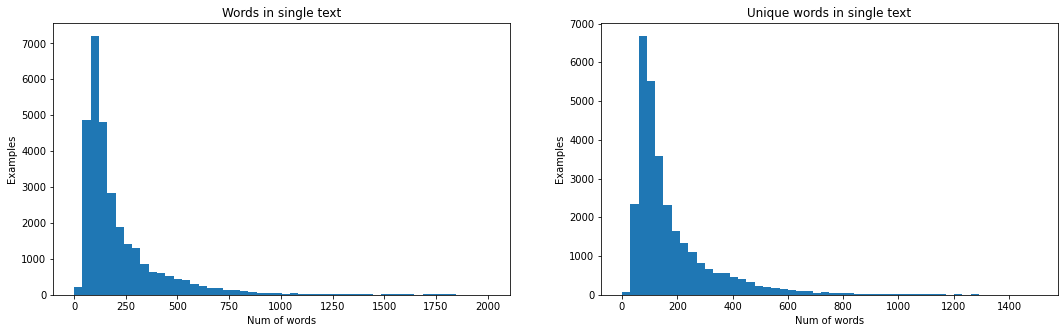

In [31]:
draw_stat_hists(text_stats, 50, label='text')

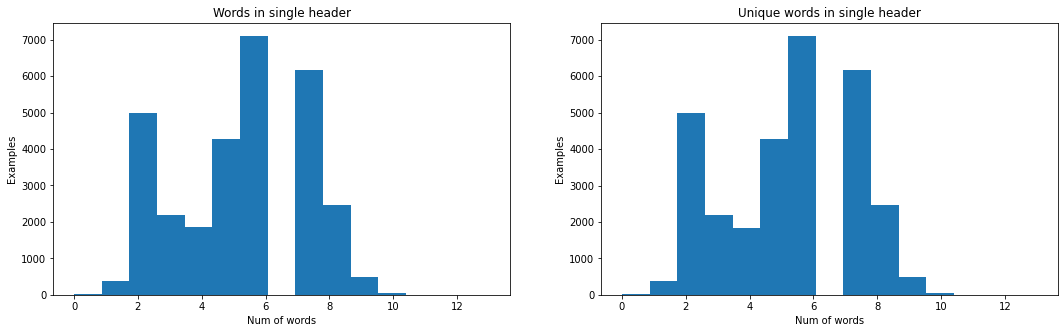

In [33]:
draw_stat_hists(header_stats, 15, label='header')